# TM10007 Assignment template

In [55]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Data loading
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


## Import packages and functions

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import naive_bayes
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from scipy.stats import randint
from scipy.interpolate import interp1d
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz
from sklearn.preprocessing import robust_scale
from scipy.stats import shapiro
import scipy.stats as stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn import svm

## Description of the data 
- Checking for infinite numbers and NANs
- Checking whether the data is normally distributed
- Calculating correlation between features 
- Calculating p-values between features, to see if they significantly differ from each other

#### Checking for infinite numbers and NANs

In [ ]:
# Checking for infinite numbers and NANs
def check_inf_and_nan(data, column):
    """Check if inf and nan values are present"""
    if np.isinf(data[f'{column}']).any() == True:
        return True
    if np.isnan(data[f'{column}']).any() == True:
        return True
    return False

#### Checking whether the data is normally distributed

In [ ]:
# Data loading
data = load_data()
X_scaled = robust_scale(data[data.columns[1:]])
data[data.columns[1:]] = X_scaled


def normal_distribution(data):
    '''
    This function checks the normal distribution of features in the dataset and performs statistical tests.
    '''
    lipoma = data[data['label'] == 'lipoma']
    liposarcoma = data[data['label'] == 'liposarcoma']

    normally_distributed_features = []  # List to store normally distributed features
    statistically_significant_features = []  # List to store statistically significant features
    statistically_significant_features_number = []  # List to store statistically significant features number

    # Loop through all features (excluding the label column)

    for feature_number, feature in enumerate(data.columns[1:], start=1):
        selected_feature_lipoma = lipoma[feature]
        selected_feature_liposarcoma = liposarcoma[feature]

        # Shapiro-Wilk test for normality
        stat_lipoma, p_lipoma = shapiro(selected_feature_lipoma)
        stat_liposarcoma, p_liposarcoma = shapiro(selected_feature_liposarcoma)

        if p_lipoma > 0.05 and p_liposarcoma > 0.05:
            # print(f"Feature '{feature}' is normally distributed")
            normally_distributed_features.append(feature)

            # Perform t-test for statistical significance
            stat, p_value = stats.ttest_ind(selected_feature_lipoma, selected_feature_liposarcoma)

            # Correct for multiple comparisons (Bonferroni correction)
            p_value *= len(normally_distributed_features)
                           
            if p_value < 0.05:
                print(f"Feature '{feature}' is statistically significant (p-value: {p_value:.4f})")

                # Save the feature number
                statistically_significant_features.append(feature)
                statistically_significant_features_number.append(feature_number)
    return lipoma, liposarcoma, normally_distributed_features, statistically_significant_features, statistically_significant_features_number

# call the function
[lipoma, liposarcoma,
 normally_distributed_features,
 statistically_significant_features,
 statistically_significant_features_number] = normal_distribution(data)

# Plot scatter of statistically significant features
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[1]], color='blue', label='lipoma', s=3)
axis[0].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[1]], color='red', label='liposarcoma', s=3)
axis[0].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[0].set_ylabel(f"Feature number {statistically_significant_features_number[1]}")
axis[0].legend()

axis[1].scatter(lipoma[statistically_significant_features[0]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[1].scatter(liposarcoma[statistically_significant_features[0]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[1].set_xlabel(f"Feature number {statistically_significant_features_number[0]}")
axis[1].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[1].legend()

axis[2].scatter(lipoma[statistically_significant_features[1]], lipoma[statistically_significant_features[2]], color='blue', label='lipoma', s=3)
axis[2].scatter(liposarcoma[statistically_significant_features[1]], liposarcoma[statistically_significant_features[2]], color='red', label='liposarcoma', s=3)
axis[2].set_xlabel(f"Feature number {statistically_significant_features_number[1]}")
axis[2].set_ylabel(f"Feature number {statistically_significant_features_number[2]}")
axis[2].legend()

plt.show()

# Train a logistic regression model with the statistically significant features

# Select the statistically significant features
X = data[statistically_significant_features]
y = data['label'].apply(lambda x: 1 if x == 'liposarcoma' else 0)  # Convert labels to binary (0 for lipoma, 1 for liposarcoma)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
models = [SVC(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
for model_instance in models:
    # Fit the model on the training data
    model_instance.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model_instance.predict(X_test)
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model_instance.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

# Train different SVM models with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model.__class__.__name__}, Kernel: {kernel}, Model Accuracy: {accuracy:.4f}")


# Train different SVM models with a grid search for hyperparameter tuning
param_dist = {'gamma': np.logspace(-7, 1, 13), 'C' : np.logspace(-1, 6, 13)}

model = RandomForestClassifier(random_state=42)

rand_search_SVC = GridSearchCV(SVC(kernel='rbf'), 
                                param_grid = param_dist, 
                                cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42))
rand_search_SVC.fit(X_train, y_train)
best_rf = rand_search_SVC.best_estimator_
print('Best hyperparameters:',  rand_search_SVC.best_params_)
accuracy = accuracy_score(y_test, best_rf.predict(X_test))
print(f"Training model: {best_rf.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

# Make a learning curve with the best model
model = SVC(kernel='rbf')
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__} with SVC kernel='rbf'")
plt.show()

#### Calculating correlation between features

In [ ]:
# Correlation between features
def correlation_features(data):
    '''
    This function calculates the correlation matrix between all features, seperately for the lipoma and liposarcoma groups. 
    For each feature combination (feature pair) it is determined if there is no correlation (>-0.5 and <0.5) in both groups.
    The amount of feature pairs without correlation and it's percentage is printed.
    '''
    data_lipoma = data[data['label'] == 'lipoma']
    data_lipoma.pop('label')
    corr_lipoma = data_lipoma.corr(method='pearson')
    no_corr_lipoma = (corr_lipoma>-0.5) & (corr_lipoma<0.5)
    
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    data_liposarcoma.pop('label')
    corr_liposarcoma = data_liposarcoma.corr(method='pearson')
    no_corr_liposarcoma = (corr_liposarcoma>-0.5) & (corr_liposarcoma<0.5)
    
    no_corr = no_corr_lipoma & no_corr_liposarcoma
    no_corr_count = 0
    for index, Series in no_corr.iterrows():
        for counts in Series:
            if counts == True:
                no_corr_count += 1

    no_corr_amount = (no_corr_count)/2
    feature_pairs = ((len(no_corr.index)-1)*len(no_corr.index))/2
    no_corr_percentage = no_corr_amount / feature_pairs * 100
    
    print(f'The amount of feature pairs without correlation is {no_corr_amount} out of {feature_pairs} feature pairs ({no_corr_percentage:5.4}%).')

correlation_features(data)

#### Calculating p-values 

In [ ]:
def calculate_p_values(data):
    """Calculates the p_values for every feature in the data between the lipoma and liposarcoma group"""
    data_lipoma = data[data['label'] == 'lipoma']
    data_liposarcoma = data[data['label'] == 'liposarcoma']
    p_values = pd.Series(0.0,index=data.columns)
    for column in data.columns:
        if any(isinstance(value, str) for value in data[f'{column}']):
            p_values = p_values.drop(f'{column}')
            print(f'found a string in column "{column}". Did not use this column for the classifier')
            continue
        if check_inf_and_nan(data, column):
            print(f'data error in column {column}. Check for NaNs and infinite values')
        stat, p = (stats.mannwhitneyu(data_lipoma[f'{column}'],data_liposarcoma[f'{column}'], axis=0))
        if p == 1.0:
            p_values = p_values.drop(f'{column}')
            continue
        p_values[f'{column}'] = p
    p_values = p_values.sort_values()
    return p_values

The amount of feature pairs without correlation is 92524.0 out of 121278.0 feature pairs (76.29%).


## Preprocessing of the data
- Anova feature selection??
- Other type of feature selection? 

## Classifiers 
In this section, multiple classifiers are tested and their performance is evaluated using accuracy, sensitivity, specifity and ROC curves.

To train and test these classifiers, a definition is written to split the data.

#### Split data

In [ ]:
def split_data(data,split=5,n=5):
    """ Docstring for split_data"""
    train_ratio = 1/split
    split_length_max = int(np.round(train_ratio * (data.shape[0]) * n))
    features = data.drop(columns=['label'])
    label = data['label']
    split_length_min = int(np.round(train_ratio * (data.shape[0]) * (n-1)))
    features_test = features[split_length_min:split_length_max]
    features_train = features.loc[~features.index.isin(features_test.index)]
    label_test = label[split_length_min:split_length_max]
    label_train = label.loc[~label.index.isin(label_test.index)]
    return features_train,features_test,label_train,label_test

#### Linear 

#### Logistic regression
A logistic regression model is trained with the statistically significant features. 

In [ ]:
# Select the statistically significant features
X = data[statistically_significant_features]
y = data['label'].apply(lambda x: 1 if x == 'liposarcoma' else 0)  # Convert labels to binary (0 for lipoma, 1 for liposarcoma)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
models = [SVC(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]
for model_instance in models:
    # Fit the model on the training data
    model_instance.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model_instance.predict(X_test)
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model_instance.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

#### Naive Bayes
There are multiple ways to compute a Naive Bayes. Here, the Gaussian method is applied. The other types of Naive Bayes are not possible
- nb_bernoulli = naive_bayes.BernoulliNB() --> not possible, since the features need to be binary
- nb_complement = naive_bayes.ComplementNB() --> not possible, since the input needs to be only integers
- nb_categorical = naive_bayes.CategoricalNB() --> not possible, since the input needs to be categorical
- nb_multinomial = naive_bayes.MultinomialNB() --> not possible, since the input needs to be only integers

Naive Bayes is tested using multiple feature selection methods: 
- Based on p-values
- With Greedy forward feature selection

found a string in column "label". Did not use this column for the classifier


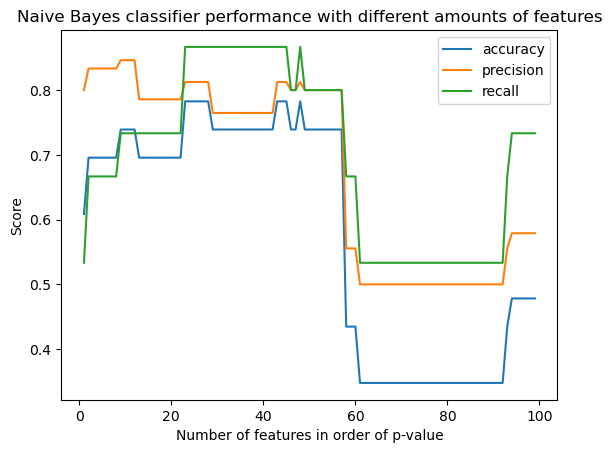

In [ ]:
# Naive Bayes classifiers based on p-values
def naive_bayes_classifier(data):
    '''
    Calculates the accuracy, precision and recall of the Gaussian Naive Bayes classifiers if the amount
    of
    '''
    p_values = calculate_p_values(data)
    features_train, features_test, label_train, label_test = split_data(data, 0.8)
    accuracy = []
    precision = []
    recall = []
    feature = []

    # Performance of naive bayes classifiers for increasing amount of features in order of p-value
    for features in range(1,100):
        selected_features = p_values.index[0:features]
        features_train_selected = features_train[selected_features]
        features_test_selected = features_test[selected_features]

        nb_gaussian = naive_bayes.GaussianNB()
        nb_gaussian.fit(features_train_selected, label_train)
        label_pred = nb_gaussian.predict(features_test_selected)

        accuracy.append(accuracy_score(label_test, label_pred))
        precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
        recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        feature.append(features)

    # Plot the results
    fig, axis = plt.subplots()
    axis.plot(feature,accuracy, label='accuracy')
    axis.plot(feature,precision, label='precision')
    axis.plot(feature,recall, label='recall')
    plt.xlabel('Number of features in order of p-value')
    plt.ylabel('Score')
    plt.title('Naive Bayes classifier performance with different amounts of features')
    plt.legend()
    plt.show()

    # Other types of naive bayes classifier are excluded:
    # nb_bernoulli = naive_bayes.BernoulliNB() --> not possible, since the features need to be binary
    # nb_complement = naive_bayes.ComplementNB() --> not possible, since the input needs to be only integers
    # nb_categorical = naive_bayes.CategoricalNB() --> not possible, since the input needs to be categorical
    # nb_multinomial = naive_bayes.MultinomialNB() --> not possible, since the input needs to be only integers

naive_bayes_classifier(data)

# Naive Bayes using Greedy forward feature selection
def perform_sfs(features_train, label_train, model, n_splits=5):
    """
    Voer Sequential Feature Selection uit voor het gekozen model.

    Parameters:
        features_train (pd.DataFrame): De training features.
        label_train (pd.Series): De training labels.
        model (sklearn model): Het model voor feature selection.
        n_splits (int): Het aantal folds voor cross-validatie.
        
    Returns:
        list: Geselecteerde features
    """
    sfs = SequentialFeatureSelector(
        model,
        n_features_to_select='auto',  # Kies automatisch het aantal features
        tol=0.01,                     # Stop als de scoreverbetering kleiner is dan 0.01
        direction='forward',
        scoring='accuracy',           # Gebruik accuracy als scoremaat
        cv=n_splits,                  # 5-fold cross-validatie
        n_jobs=-1                      # Gebruik alle cores voor parallel processing
    )
    
    # Pas SFS toe op de trainingsdata
    sfs.fit(features_train, label_train)
    
    # Geselecteerde features
    selected_features = features_train.columns[sfs.get_support()]
    
    return selected_features

# Functie om het Naive Bayes model te trainen en de accuracy te berekenen
def train_and_evaluate(features_train, features_test, label_train, label_test, selected_features):
    """
    Train het Naive Bayes model en evalueer de accuracy.

    Parameters:
        features_train (pd.DataFrame): De training features.
        features_test (pd.DataFrame): De test features.
        label_train (pd.Series): De training labels.
        label_test (pd.Series): De test labels.
        selected_features (list): De geselecteerde features uit SFS.

    Returns:
        float: De accuracy op de testdata.
    """
    # Selecteer de features die zijn gekozen door SFS
    features_train_sel = features_train[selected_features]
    features_test_sel = features_test[selected_features]
    
    # Train het Naive Bayes model
    gnb = naive_bayes.GaussianNB()
    gnb.fit(features_train_sel, label_train)
    
    # Maak voorspellingen op de testset
    y_pred = gnb.predict(features_test_sel)
    
    # Bereken de accuracy
    acc = accuracy_score(label_test, y_pred)
    
    return acc

# Functie om 5 splits uit te voeren en de accuracies te berekenen
def evaluate_model(data, n_splits=5):
    """
    Voer het model uit over 5 verschillende splits van de data en bereken de accuracies.

    Parameters:
        data (pd.DataFrame): De volledige dataset.
        n_splits (int): Het aantal splits voor cross-validation.

    Returns:
        tuple: accuracies (list), gemiddelde_accuracy (float)
    """
    accuracies = []

    for i in range(n_splits):
        print(f"Uitvoering {i + 1}:")
        
        # Split de data met een andere random seed elke keer
        features_train, features_test, label_train, label_test = split_data(data, train_ratio=0.8, random_state=i)
        
        # Voer Sequential Feature Selection uit
        selected_features = perform_sfs(features_train, label_train, GaussianNB(), n_splits=5)
        
        # Train het model en evalueer de accuracy
        acc = train_and_evaluate(features_train, features_test, label_train, label_test, selected_features)
        accuracies.append(acc)
        
        print(f"Accuracy op testset voor split {i + 1}: {acc:.4f}\n")
    
    # Gemiddelde accuracy over alle splits
    avg_accuracy = np.mean(accuracies)
    
    return accuracies, avg_accuracy

# Voer de evaluatie uit
accuracies, avg_accuracy = evaluate_model(data, n_splits=5)

# Resultaten tonen
print("Accuracies voor alle splits:")
print(accuracies)
print(f"Gemiddelde accuracy over 5 splits: {avg_accuracy:.4f}")

#### KNN classifier 
The KNN classifier is based on distance, so the data is scaled 5 splits are performed and the optimal k is determined using 5-fold cross validation. ROC curves are made for each split to visualize the True Positive Rate and the False Positive Rate

Processing Split 1
Optimal k for Split 1: 9
Test Accuracy for Split 1 with optimal k (9): 0.5217
Test AUC for Split 1 with optimal k (9): 0.5644
Processing Split 2
Optimal k for Split 2: 9
Test Accuracy for Split 2 with optimal k (9): 0.5217
Test AUC for Split 2 with optimal k (9): 0.5644
Processing Split 3
Optimal k for Split 3: 9
Test Accuracy for Split 3 with optimal k (9): 0.5217
Test AUC for Split 3 with optimal k (9): 0.5644
Processing Split 4
Optimal k for Split 4: 5
Test Accuracy for Split 4 with optimal k (5): 0.5652
Test AUC for Split 4 with optimal k (5): 0.5606
Processing Split 5
Optimal k for Split 5: 5
Test Accuracy for Split 5 with optimal k (5): 0.5652
Test AUC for Split 5 with optimal k (5): 0.5606


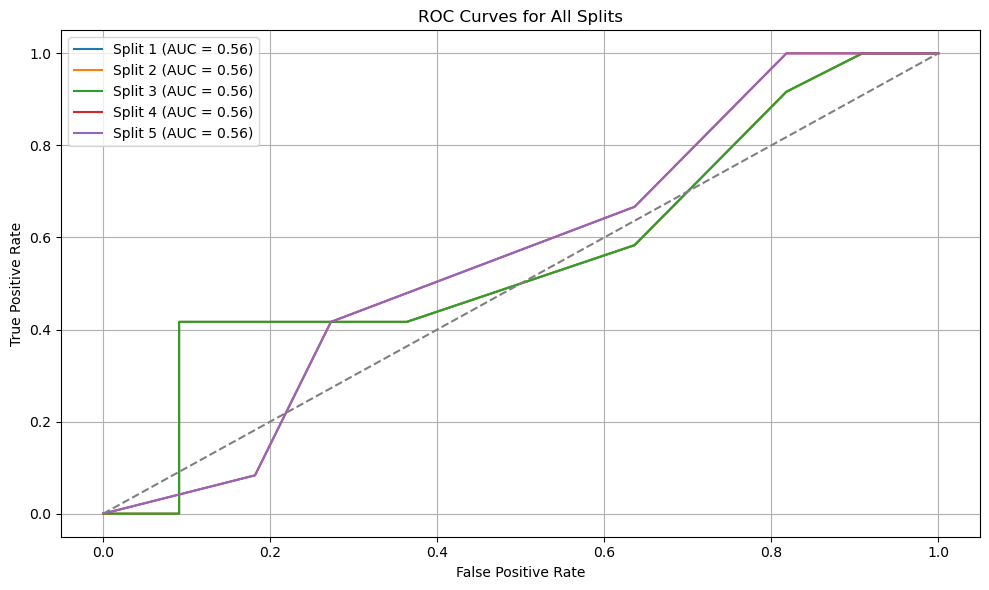

In [ ]:
# Functie voor cross-validatie met KNN 
def cross_validate_knn(data, k_values=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], random_state=42):
    """
    Voer cross-validation uit op de data, vind de beste k-waarde, train het model en test op de testset.
    
    :param data: DataFrame met de features en labels
    :param label_column: Naam van de kolom met de labels
    :param k_values: Lijst van k-waarden om te testen
    :param n_splits: Het aantal splits voor cross-validation (bijv. 5)
    :param random_state: Zaadje voor de willekeurige splits
    :return: ROC curve data voor alle splits
    """
    np.random.seed(random_state)
    # Lijst om de ROC data van alle splits op te slaan
    roc_data_all_splits = []
    
    # Loop door de splits (bijvoorbeeld 5-fold cross-validation)
    for split_index in range(1,6,1):
        print(f"Processing Split {split_index}")

        # Split de data (train/test splits voor deze specifieke fold)
        features_train, features_test, label_train, label_test = split_data(data, split=5, n=split_index)
        
        # Schaal de features met RobustScaler
        scaler = RobustScaler()
        features_train_scaled = scaler.fit_transform(features_train)
        features_test_scaled = scaler.transform(features_test)
        
        # Label encoding voor de binaire classificatie
        encoder = LabelEncoder()
        label_train_encoded = encoder.fit_transform(label_train)
        label_test_encoded = encoder.transform(label_test)
        
        # Vind de optimale k-waarde via cross-validation binnen de training data
        cv_scores = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, features_train_scaled, label_train_encoded, cv=5, scoring='accuracy')
            cv_scores.append(scores.mean())
        
        # Kies de beste k-waarde
        optimal_k = k_values[cv_scores.index(max(cv_scores))]
        print(f"Optimal k for Split {split_index}: {optimal_k}")
        
        # Train het model met de beste k
        knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
        knn_final.fit(features_train_scaled, label_train_encoded)
        
        # Test het model op de testset
        test_predictions = knn_final.predict(features_test_scaled)
        test_accuracy = accuracy_score(label_test_encoded, test_predictions)
        print(f"Test Accuracy for Split {split_index}: {test_accuracy:.4f}")
        
        # Bereken de ROC curve en AUC voor de testset
        y_pred_prob = knn_final.predict_proba(features_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(label_test_encoded, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        print(f"Test AUC for Split {split_index}: {roc_auc:.4f}")
        
        # Sla de ROC curve data voor deze split op
        roc_data_all_splits.append((fpr, tpr, roc_auc))
    
    return roc_data_all_splits

# Functie om de ROC curves te plotten
def plot_roc_curves(roc_data_all_splits):
    """
    Plot de ROC curves voor alle splits.
    
    :param roc_data_all_splits: Lijst met ROC-gegevens voor elke split
    """
    plt.figure(figsize=(10, 6))

    # Plot elke ROC-curve
    for split_index, (fpr, tpr, roc_auc) in enumerate(roc_data_all_splits):
        plt.plot(fpr, tpr, label=f'Split {split_index + 1} (AUC = {roc_auc:.2f})')

    # Voeg de diagonaal (willekeurige voorspellingen) toe
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    # Labels en titel
    plt.title('ROC Curves for All Splits')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Toon de legenda
    plt.legend()

    # Zet het raster aan voor leesbaarheid
    plt.grid(True)

    # Zorg dat de layout goed is
    plt.tight_layout()
    plt.show()


roc_data_all_splits = cross_validate_knn(data)
# Plot de ROC curves voor alle splits
plot_roc_curves(roc_data_all_splits)

#### Random Forest

KeyboardInterrupt: 

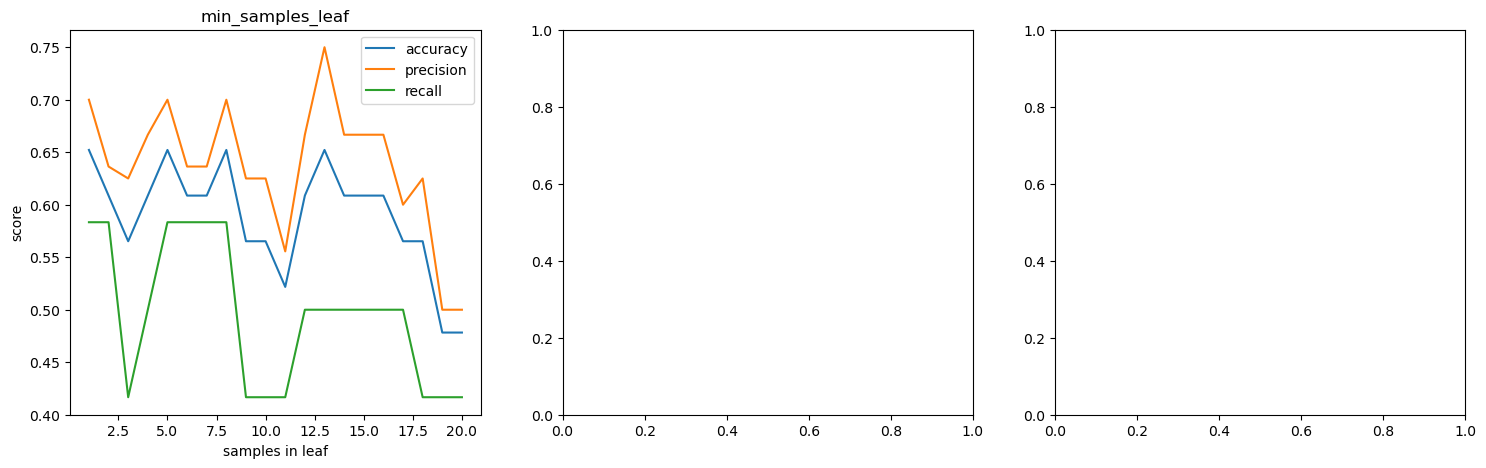

In [ ]:
def test_hyperparameter(parameter,value_max):
    accuracy = []
    precision = []
    recall = []
    values = []
    for value in range(1,(value_max+1)):
        model_test = RandomForestClassifier(**{parameter: value}, random_state=42)
        model_test.fit(features_train, label_train)
        label_pred = model_test.predict(features_test)
        accuracy.append(accuracy_score(label_test, label_pred))
        precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
        recall.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
        values.append(value)
    return accuracy,precision,recall,values

def plot_testing_values(axis, title,xlabel,ylabel,values,accuracy,precision,recall):
    axis.plot(values,accuracy, label='accuracy')
    axis.plot(values,precision, label='precision')
    axis.plot(values,recall, label='recall')
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    axis.legend()

data_lipoma = data[data['label'] == 'lipoma']
data_liposarcoma = data[data['label'] == 'liposarcoma']

split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]

fig, axis = plt.subplots(1,3, figsize=(18,5))
accuracy1, precision1, recall1, values1 = test_hyperparameter('min_samples_leaf', 20)
plot_testing_values(axis[0], 'min_samples_leaf','samples in leaf','score', values1, accuracy1, precision1, recall1)
accuracy2, precision2, recall2, values2 = test_hyperparameter('n_estimators', 200)
plot_testing_values(axis[1], 'n_estimators','trees in forest','score', values2, accuracy2, precision2, recall2)
accuracy3, precision3, recall3, values3 = test_hyperparameter('max_depth', 20)
plot_testing_values(axis[2], 'max_depth','max depth of trees','score', values3, accuracy3, precision3, recall3)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 75}
Accuracy: 0.6086956521739131, Specificity: 0.8181818181818182, Sensitivity: 0.4166666666666667
Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 7, 'n_estimators': 103}
Accuracy: 0.782608695652174, Specificity: 0.6666666666666666, Sensitivity: 0.9090909090909091
Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 7, 'n_estimators': 100}
Accuracy: 0.6521739130434783, Specificity: 0.7272727272727273, Sensitivity: 0.5833333333333334
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 75}
Accuracy: 0.782608695652174, Specificity: 0.8333333333333334, Sensitivity: 0.7272727272727273
Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 93}
Accuracy: 0.6086956521739131, Specificity: 0.6363636363636364, Sensitivity: 0.5833333333333334


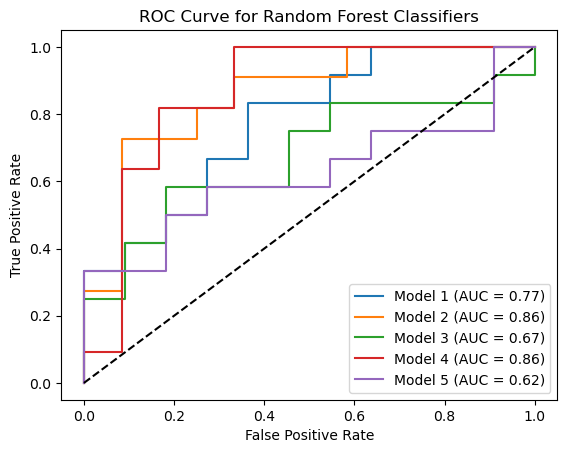

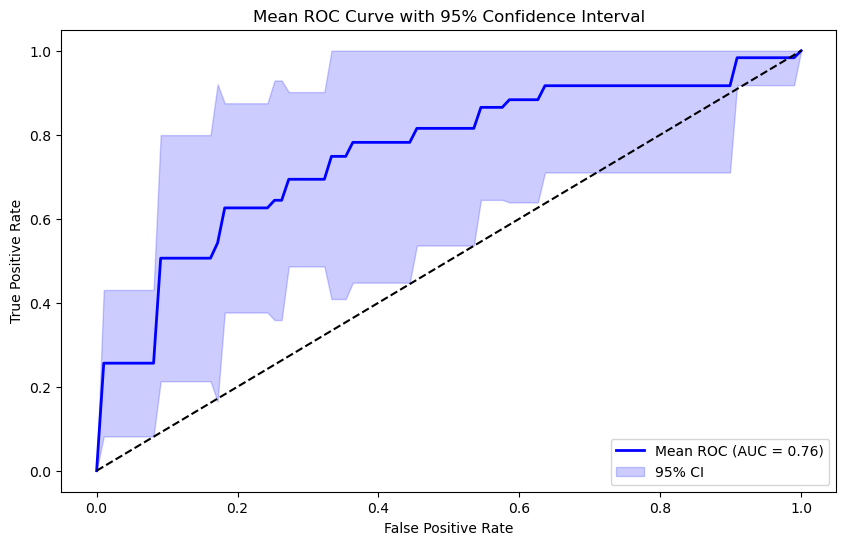

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
param_dist = {'n_estimators': randint(1,150),
              'max_depth': randint(2,10),
              'min_samples_leaf': randint(3,10)}

model = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=42)

n = 5
accuracy = []
specificity = []
sensitivity = []
all_roc = np.linspace(0, 1, 100)
roc_list = []
for i in range(1,n+1):
    split_lipoma = split_data(data_lipoma, n, i)
    split_liposarcoma = split_data(data_liposarcoma, n, i)
    features_train, features_test, label_train, label_test = [
        pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
        ]

    rand_search.fit(features_train, label_train)
    best_rf = rand_search.best_estimator_
    print('Best hyperparameters:',  rand_search.best_params_)

    label_pred = best_rf.predict(features_test)
    label_prob = best_rf.predict_proba(features_test)[:, 1]

    accuracy.append(accuracy_score(label_test, label_pred))
    specificity.append(recall_score(label_test, label_pred, pos_label='lipoma'))
    sensitivity.append(recall_score(label_test, label_pred, pos_label='liposarcoma'))
    print(f'Accuracy: {accuracy[i-1]}, Specificity: {specificity[i-1]}, Sensitivity: {sensitivity[i-1]}')

    fpr, tpr, _ = roc_curve(label_test, label_prob, pos_label='liposarcoma')
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Model {i} (AUC = {roc_auc:.2f})')

    interp_roc = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(all_roc)
    interp_roc[0] = 0
    roc_list.append(interp_roc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifiers')
plt.legend(loc='lower right')
plt.show()

roc_array = np.array(roc_list)
mean_roc = np.mean(roc_array, axis=0)
std_roc = np.std(roc_array, axis=0)
ci_upper = np.minimum(mean_roc + 1.96 * std_roc, 1)
ci_lower = np.maximum(mean_roc - 1.96 * std_roc, 0)
mean_auc = auc(all_roc, mean_roc)

plt.figure(figsize=(10, 6))
plt.plot(all_roc, mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
plt.fill_between(all_roc, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with 95% Confidence Interval')
plt.legend(loc='lower right')
plt.show()

for i in range(1):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=features_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=True, 
                               proportion=False)
    graph = graphviz.Source(dot_data)
    display(graph)

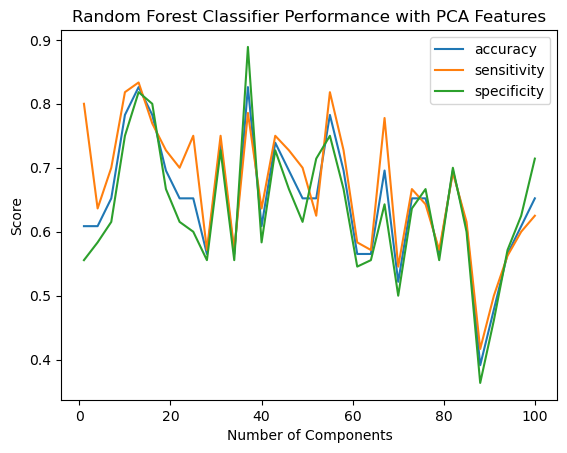

In [12]:
accuracy = []
precision = []
recall = []
tree = []
for components in range(1, 101, 3):
    pca = PCA(n_components=components)  # Keep 95% of variance
    pca_transform = pca.fit_transform(data[data.columns[1:]])
    data_pca = pd.DataFrame(data=pca_transform, columns=[f'PC{i+1}' for i in range(pca_transform.shape[1])])
    data_pca['label'] = data['label'].values  # Add the label column back to the PCA DataFrame

    data_lipoma_pca = data_pca[data_pca['label'] == 'lipoma']
    data_liposarcoma_pca = data_pca[data_pca['label'] == 'liposarcoma']

    split_lipoma_pca = split_data(data_lipoma_pca, 0.8)
    split_liposarcoma_pca = split_data(data_liposarcoma_pca, 0.8)
    features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma_pca, split_liposarcoma_pca)
    ]

    model_test = RandomForestClassifier(min_samples_leaf=5, random_state=42, n_estimators=20)
    model_test.fit(features_train, label_train)
    label_pred = model_test.predict(features_test)
    accuracy.append(accuracy_score(label_test, label_pred))
    precision.append(precision_score(label_test, label_pred, pos_label='liposarcoma'))
    recall.append(precision_score(label_test, label_pred, pos_label='lipoma'))
    #print(f"Components: {components}, Accuracy: {accuracy:.4f}, Sensitivity: {precision:.4f}, Specificity: {recall:.4f}")

# Plot components vs accuracy, precision and recall in 1 figure
fig, axis = plt.subplots()
axis.plot(range(1, 101, 3), accuracy, label='accuracy')
axis.plot(range(1, 101, 3), precision, label='sensitivity')
axis.plot(range(1, 101, 3), recall, label='specificity')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Random Forest Classifier Performance with PCA Features')
plt.legend()
plt.show()

In [ ]:
# forward selection method
# sort the features by p-value
p_values = calculate_p_values(data)

print(p_values[:20])
data_p_values = pd.DataFrame(p_values, columns=['p_value'])
data_p_values['feature'] = data_p_values.index
data_p_values = data_p_values.reset_index(drop=True)

# Make a loop adding features one by one and check the accuracy of the model
features = []
accuracy = [0]
accuracy_score_list = []

# Initialize a DataFrame to store accuracy scores for each feature
accuracy_df = pd.DataFrame()

# Loop through features
for feature in range(0, 100):
    features.append(data_p_values['feature'][feature])
    features_train, features_test, label_train, label_test = train_test_split(data[features], data['label'], test_size=0.2, random_state=42, stratify=data['label'])
    
    # Store accuracy scores for the current feature
    feature_accuracies = []
    for seed in range(10):
        model = RandomForestClassifier(min_samples_leaf=5, random_state=seed, n_estimators=70)
        model.fit(features_train, label_train)
        label_pred = model.predict(features_test)
        feature_accuracies.append(accuracy_score(label_test, label_pred))
    
    # Add the accuracy scores as a column in the DataFrame
    accuracy_df[data_p_values['feature'][feature]] = feature_accuracies

found a string in column "label". Did not use this column for the classifier
PREDICT_original_sf_volume_2.5D                     1.502031e-09
PREDICT_original_sf_area_max_2.5D                   5.960145e-07
PREDICT_original_sf_area_std_2.5D                   8.663971e-07
PREDICT_original_tf_Gabor_mean_F0.2_A0.0            1.525185e-06
PREDICT_original_sf_area_avg_2.5D                   1.525185e-06
PREDICT_original_tf_Gabor_mean_F0.2_A0.79           2.188528e-06
PREDICT_original_tf_Gabor_mean_F0.05_A0.0           1.996297e-05
PREDICT_original_tf_Gabor_energy_F0.2_A0.79         8.910676e-05
PREDICT_original_tf_Gabor_energy_F0.2_A0.0          1.201762e-04
PREDICT_original_tf_Gabor_mean_F0.5_A0.0            2.456398e-04
PREDICT_original_phasef_phasecong_entropy_WL3_N5    2.680287e-04
PREDICT_original_tf_Gabor_entropy_F0.05_A0.79       3.118751e-04
PREDICT_original_tf_Gabor_entropy_F0.05_A1.57       3.118751e-04
PREDICT_original_logf_entropy_sigma5                3.326501e-04
PREDICT_origi

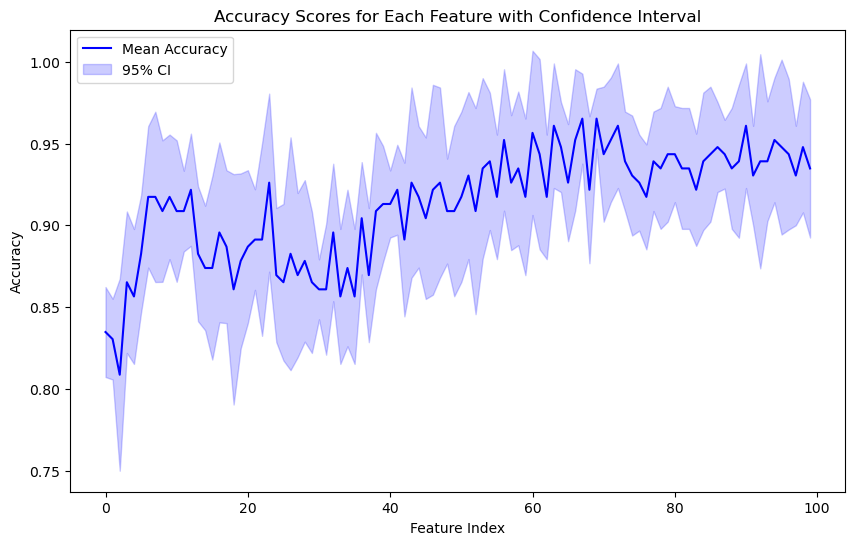

In [ ]:
# plot the accuracy scores for each feature with a confidence interval
fig, axis = plt.subplots(figsize=(10, 6))
axis.plot(range(0, 100), accuracy_df.mean(), label='Mean Accuracy', color='blue')
axis.fill_between(range(0,100), accuracy_df.mean() - accuracy_df.std(), accuracy_df.mean() + accuracy_df.std(), color='blue', alpha=0.2, label='95% CI')
axis.set_xlabel('Feature Index')
axis.set_ylabel('Accuracy')
axis.set_title('Accuracy Scores for Each Feature with Confidence Interval')
axis.legend()
plt.show()

In [ ]:
p_values = calculate_p_values(data)
p_values = p_values[:200]
top_features = p_values.index
columns_to_keep = list(top_features) + ['label']

data = load_data()
data_lipoma = data[data['label'] == 'lipoma']
data_liposarcoma = data[data['label'] == 'liposarcoma']
data_lipoma = data_lipoma[columns_to_keep]
data_liposarcoma = data_liposarcoma[columns_to_keep]

split_lipoma = split_data(data_lipoma)
split_liposarcoma = split_data(data_liposarcoma)
features_train, features_test, label_train, label_test = [
    pd.concat([x, y]) for x, y in zip(split_lipoma, split_liposarcoma)
    ]

linear_model = svm.LinearSVC(random_state=42, penalty='l1')
linear_model.fit(features_train, label_train)
label_pred = linear_model.predict(features_test)

accuracy = (accuracy_score(label_test, label_pred))
specificity = (recall_score(label_test, label_pred, pos_label='lipoma'))
sensitivity = (recall_score(label_test, label_pred, pos_label='liposarcoma'))

print(f'accuracy: {accuracy}, specificity: {specificity}, sensitivity: {sensitivity}')

SVC_model = svm.SVC(kernel='rbf', random_state=42)
param_dist = {'gamma': np.logspace(-9,3,13),
            'C': np.logspace(-2,10,13)}

model = RandomForestClassifier(random_state=42)

rand_search_SVC = RandomizedSearchCV(SVC_model, 
                                param_distributions = param_dist, 
                                n_iter=5, 
                                cv=5,
                                random_state=42)
rand_search_SVC.fit(features_train, label_train)
best_rf = rand_search_SVC.best_estimator_
print('Best hyperparameters:',  rand_search_SVC.best_params_)
label_pred = rand_search_SVC.predict(features_test)

accuracy = (accuracy_score(label_test, label_pred))
specificity = (recall_score(label_test, label_pred, pos_label='lipoma'))
sensitivity = (recall_score(label_test, label_pred, pos_label='liposarcoma'))

print(f'accuracy: {accuracy}, specificity: {specificity}, sensitivity: {sensitivity}')

NU_model = svm.NuSVC(random_state=42)
NU_model.fit(features_train, label_train)
label_pred = NU_model.predict(features_test)

accuracy = (accuracy_score(label_test, label_pred))
specificity = (recall_score(label_test, label_pred, pos_label='lipoma'))
sensitivity = (recall_score(label_test, label_pred, pos_label='liposarcoma'))

print(f'accuracy: {accuracy}, specificity: {specificity}, sensitivity: {sensitivity}')

found a string in column "label". Did not use this column for the classifier


c:\Users\sjoer\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.5217391304347826, specificity: 0.5454545454545454, sensitivity: 0.5


KeyboardInterrupt: 

#### Support Vector Machine


In [ ]:
# Train different SVM models with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Training model: {model.__class__.__name__}, Kernel: {kernel}, Model Accuracy: {accuracy:.4f}")


# Train different SVM models with a grid search for hyperparameter tuning
param_dist = {'gamma': np.logspace(-7, 1, 13), 'C' : np.logspace(-1, 6, 13)}

model = RandomForestClassifier(random_state=42)

rand_search_SVC = GridSearchCV(SVC(kernel='rbf'), 
                                param_grid = param_dist, 
                                cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42))
rand_search_SVC.fit(X_train, y_train)
best_rf = rand_search_SVC.best_estimator_
print('Best hyperparameters:',  rand_search_SVC.best_params_)
accuracy = accuracy_score(y_test, best_rf.predict(X_test))
print(f"Training model: {best_rf.__class__.__name__}, Model Accuracy: {accuracy:.4f}")

# Make a learning curve with the best model
model = SVC(kernel='rbf')
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__} with SVC kernel='rbf'")
plt.show()